# EN.605.646.81: Natural Language Processing, Fall 2024
# Applied and Computational Mathematics
# Johns Hopkins University
# Andres Davila Corujo

# Lab 4: Word Embeddings

## Part A: Exploring Static Word Embeddings

Part A of this lab lets you practice working with static neural word embeddings.  We'll use Python libraries that learn static word embeddings, perform vector operations on word vectors, and create and manipulate contextual embeddings. Most data for this lab are obtained from the file lab04.zip on Canvas.

You may run your code on any platform you like. Colab ([```colab.research.google.com```](https://colab.research.google.com)) is a reasonable choice. This notebook should run on Colab without modification. To avoid running into resource limits in future labs, you might consider getting a paid Colab account for the duration of the course. You shouldn't need a paid account for this lab, but once we are making heavier use of the GPU, a paid account will reduce your headaches. And it's far cheaper than a textbook.

This lab is based in part on [Jason Brownlee's tutorial](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/). Reviewing that tutorial will among other things give you one way to use principal components analysis to visualize embeddings in Python.

We'll use the following libraries. They are pre-loaded on Colab, but if you're doing this on your own machine you might need to pip install them.

In [1]:
%pip install gensim numpy matplotlib scikit-learn spacy nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.0 MB/s eta 0:00:00
  Using cached matplotlib-3.9.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.8/114.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.6 MB/s eta 0:00:00
  Using cached smart_open-7.0.5-py3-none-any.whl.metadata (24 kB)
  Using cached contourpy-1.3.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.7/163.7 kB 11.4 MB/s eta 0:00:00
  Using cached pillow-10.4.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.1.4-py3-none-any.whl.metadata (5.1 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
  Using cached spacy_legacy-3.0.12-py2.py3

In [11]:
import gensim
from gensim.models import Word2Vec, KeyedVectors
import matplotlib
from matplotlib import pyplot as plt
import sklearn
from sklearn.decomposition import PCA
import spacy
from nltk.tokenize import word_tokenize
import spacy
import numpy as np
from itertools import islice

When using Colab, we will load our data files from Google drive. When mounting our drive the first time, Google will verify ownership of the drive before granting access to it.

In [ ]:
from google.colab import drive
gdrive_mount = '/content/drive'
drive.mount(gdrive_mount, force_remount=True)

Create directories for our data and models. Note that we need to put double quotes around the directory name to run this in a Notebook because in their infinite wisdom Google has placed a space in the default gdrive path.

In [4]:
# Change this path if you'd like to work on your lab in a different directory:
labdir = '.'
!mkdir -p "$labdir"
!mkdir -p "$labdir/data"
!mkdir -p "$labdir/models"
%cd "$labdir"
!ls

/Users/adavila/Documents/andres/jhu/605.646 NLP/lab4
Lab04_Fall2024.ipynb models
data                 small.txt


You should download the file small.txt.zip from Canvas, unzip it, and place the five resulting file in the data directory. You should also obtain a set of pre-calculated embedding vectors called ```GoogleNews-vectors-negative300.bin.gz``` from [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g), ungzip them, and place them in the data directory.

We'll use SpaCy to tokenize our text. There are 50,000 lines in small.txt, so this may take a while. To speed things up a bit, we'll turn off some of SpaCy's features.

In [14]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 75.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [15]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

We'll treat every line as a sentence to be tokenized. We'll run SpaCy's tokenizer over the line, then pull out the text of the tokens (ignoring punctuation). We will end up with a list of lists, one per line, where each contained list is a list of the words in the sentence as strings.

In [16]:
with open('data/small.txt', 'r') as infile:
  collection = [[token.text for token in nlp(line.lower()) if not token.is_punct] for line in infile]

Safety check to make sure our data was loaded correctly:

In [17]:
assert len(collection) == 50000, "Load of small.txt failed"
print(collection[42])

['you', "'ve", 'literally', 'taken', 'on', 'the', 'energy', 'of', 'this', 'dear', 'one', 'in', 'your', 'life', 'and', 'there', "'s", 'some', 'interesting', 'dynamics', 'here', 'and', 'i', 'hope', 'you', 'do', "n't", 'mind', 'me', 'being', 'a', 'little', 'bit', 'direct', '\n']


Build a 100-dimensional Word2Vec model, using gensim's implementation of Word2Vec.

**(10 points)** To visualize the vector relationships between related words, make a 2-dimensional projection using PCA (principal component analysis). Create a scatter plot for this list of words:
	`['paris', 'istanbul', 'moscow', 'france', 'turkey', 'russia', 'cat', 'dog', 'truck', 'train', 'two', 'three', 'four']`.
You may use the SKLearn PCA package, imported above, or your own favorite package. Be sure to run the PCA over all of the words in the model, not just this list of words.

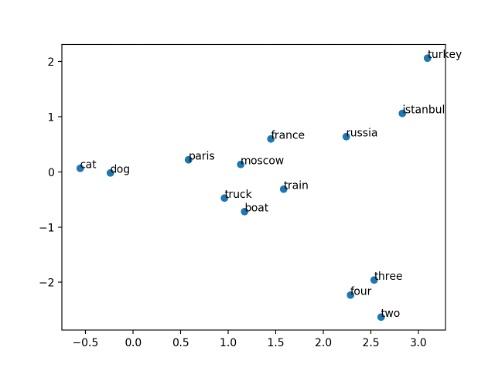

Your plot may look different.  However, semantically related words should be near each other in this two-dimensional representation.  You may also notice that the vectors for (france - paris) and (russia - moscow) are similar.

In [21]:
model = Word2Vec(sentences=collection, vector_size=100, window=5, min_count=2, sg=1, negative=8)
print(model)

Word2Vec<vocab=26733, vector_size=100, alpha=0.025>


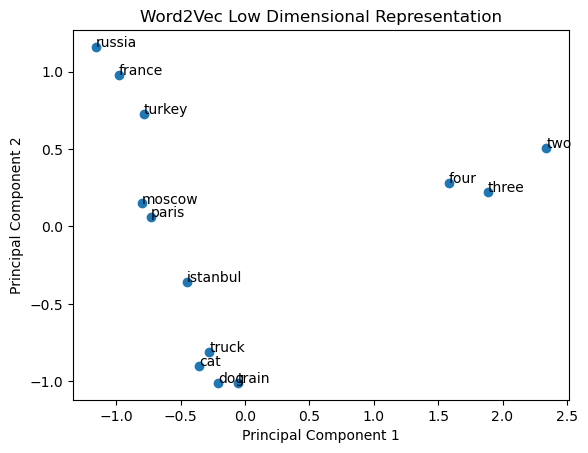

In [30]:
pca = PCA(n_components=2)

words = ['paris', 'istanbul','moscow','france','turkey','russia','cat','dog','truck','train','two','three','four']
embeddings = [model.wv[word] for word in words]

two_d_embeddings = pca.fit_transform(embeddings)


plot_data = {
    'pc1': two_d_embeddings[:, 0],
    'pc2': two_d_embeddings[:, 1],
    'labels': words
}

plt.scatter(x=two_d_embeddings[:, 0], y=two_d_embeddings[:, 1])
# Label each point
for i, word in enumerate(words):
    plt.text(two_d_embeddings[:, 0][i], two_d_embeddings[:, 1][i], word)

plt.title('Word2Vec Low Dimensional Representation')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

#### Comment
The plot above shows the embeddings for each word from the Word2Vec model in a low dimensional space from embeddings. We can see the model does a pretty good job of capturing context. Numbers are grouped together on the middle right, cities are somewhat grouped together in the middle left, countries in the top left and words germane to animals in the bottom middle. I can see how it might place the word 'truck' close to cat, dog and train as what we can picture in movies is a dog sitting on a truck.

Better quality embeddings can be obtained from larger text. Let's load vectors built off of a much larger collection: the Google News pretrained embeddings. We will wipe out our original model to preserve memory. We won't be able to perform the principal components analysis on this new model when limited by Colab's basic memory allocation. Note that this model is not case-normalized.

In [19]:
model = KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin", binary=True)

We can verify that the model contains word vectors.

In [32]:
print(model['purple'])

[ 1.21093750e-01 -4.68750000e-02  3.58886719e-02  2.83203125e-01
 -1.66015625e-01 -8.05664062e-02  6.17675781e-02 -4.84375000e-01
 -9.47265625e-02 -4.88281250e-03 -1.34765625e-01  1.13281250e-01
  2.12890625e-01  9.91210938e-02 -1.34765625e-01 -2.25585938e-01
 -2.42187500e-01  1.56250000e-01 -6.98242188e-02 -2.18750000e-01
 -1.47460938e-01  2.98828125e-01 -1.01928711e-02 -2.21679688e-01
 -2.25585938e-01 -3.17382812e-02 -1.73828125e-01  4.68750000e-02
  2.50244141e-02 -2.21679688e-01 -4.39453125e-02  2.41210938e-01
  1.25976562e-01  1.62353516e-02 -1.08398438e-01  6.83593750e-02
  3.63281250e-01 -4.94384766e-03 -8.83789062e-02  2.22656250e-01
  7.32421875e-02 -8.34960938e-02 -4.71191406e-02 -2.69531250e-01
  1.26953125e-01 -8.30078125e-02  9.33837891e-03 -2.46093750e-01
 -7.56835938e-02  1.45507812e-01 -1.92382812e-01  1.26953125e-01
  1.85546875e-01 -3.05175781e-02  4.78515625e-02  4.73022461e-03
 -1.25000000e-01 -1.16210938e-01 -7.37304688e-02 -8.30078125e-02
 -1.94335938e-01  1.11816

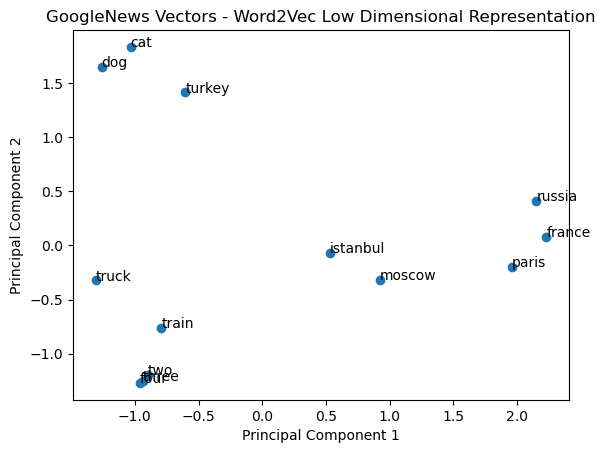

In [34]:
# let's see if my computer handles creating and plotting the embeddings for the list of words using the new model
pca = PCA(n_components=2)

words = ['paris', 'istanbul','moscow','france','turkey','russia','cat','dog','truck','train','two','three','four']
embeddings = [model[word] for word in words]

two_d_embeddings = pca.fit_transform(embeddings)


plot_data = {
    'pc1': two_d_embeddings[:, 0],
    'pc2': two_d_embeddings[:, 1],
    'labels': words
}

plt.scatter(x=two_d_embeddings[:, 0], y=two_d_embeddings[:, 1])
# Label each point
for i, word in enumerate(words):
    plt.text(two_d_embeddings[:, 0][i], two_d_embeddings[:, 1][i], word)

plt.title('GoogleNews Vectors - Word2Vec Low Dimensional Representation')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

#### Comment

The plot shows the embeddings from the Google News models for the provided words. We can see it behaving differently by the way it groups 'turkey' closer with animals than with other countries or 'istanbul'. Interestingly enough we can see the model pairs 'france' and 'paris'. This is different from our previous model where we could nearly see the relationships between cities and countries. We can also see how accurate it does for numbers, plotting them so close the labels overlap (bottom left).

Explore the gensim API. Note that sometimes Python complains about the presence of the `.wv` in the following invocations; other times it complains about its absence.

    model[x]: vector for word x
    model.wv.similarity(x, y): cosine similarity between vectors for x and y
    model.wv.distance(x, y): 1 - cosine similarity of x and y
    model.wv.most_similar(positive=[x, y, z], negative=[a, b, c], topn=k):  return k-most similar
    model.wv.most_similar_cosmul: like most_similar with a different function for three word analogies
To find the words most similar to wine:

    model.wv.most_similar (positive=['wine'])

**(2 points)** Use the API to find the words most similar to 'fascinating,' 'cultivate,' and 'eggplant,' and report your results. Is any of the most similar words a reasonable synonym or antonym for the input word?

**(2 points)** Do you believe that the similarity / distance functions are intuitive?  For example, are pairs like mother/father closer than mother/ocean? Explain your reasoning.

**(2 points)** According to the API, which words best complete the analogy, puppies is to dog as X is to cat?

**(2 points)** A classic example is queen = (king - man) + woman.  Find two other interesting analogies using the API.

**(5 points)** A pair of words might be synonyms, antonyms, similar, related, subordinate/superordinate, or unrelated. Identify at least one pair of words in each category, and compare their embeddings.  For example, you might compare plots, or compare cosines or L2 distances, etc. Given a pair of words, do you think it is possible to determine whether they are a) synonymous, b) antonymous, c) similar, d) related, e) subordinate/ superordinate, or f) unrelated, using only their embedding vectors? Give your reasoning for each category of relationship.

**(2 points)** Record any interesting observations, and report any examples you like of good or dubious performance.


In [23]:
words = ['fascinating','cultivate','eggplant']
for word in words:
    print(f"Similar words for {word}")
    display(model.most_similar(positive=[word], topn=5))

Similar words for fascinating


[('interesting', 0.7623067498207092),
 ('intriguing', 0.724511444568634),
 ('enlightening', 0.6644250750541687),
 ('captivating', 0.6459898948669434),
 ('facinating', 0.641668438911438)]

Similar words for cultivate


[('cultivating', 0.7274794578552246),
 ('cultivated', 0.6766659617424011),
 ('nurture', 0.6695471405982971),
 ('cultivates', 0.6159787178039551),
 ('develop', 0.6053071022033691)]

Similar words for eggplant


[('zucchini', 0.726477861404419),
 ('cauliflower', 0.6968439817428589),
 ('eggplants', 0.6966414451599121),
 ('bok_choy', 0.6907373070716858),
 ('bell_peppers', 0.6875451803207397)]

The model yields good interesting similar words for 'fascinating'. Fascinating to me means it is wildly interesting, so much so you can't get enough - curiosity will always get the better of you. I think the model yielded good synonyms for the word fascinating.

I define the word cultivate as both something you do physically in the ground and with relationships, i.e. it's more than just planting. The synonyms yielded aren't that great since some of them are the same root with different affixes. Outside of those, I think the model yielded good synonyms such as nurture and develop. Those are things you can physically do to some type of vegetation but to a relationship as well.

The third word, a vegetation, is pretty straight forward. I would expect the model to yield similar types of vegetations. What's interesting is why those vegetables? We could argue for all expect the bok choy, they are vegetables that are produced by the plant whereas bok choy is the plant itself. I wouldn't go as far and say this is an antonym since it is a consumable vegetable yet it does not grow the same nor is it collected the same. I won't speak to how it can be cooked since people are always inventing new ways to cook existing things.

Text(0, 0.5, 'Principal Component 2')

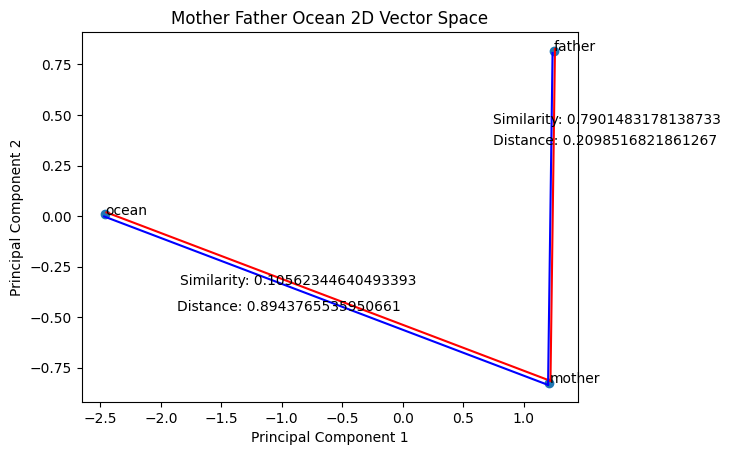

In [77]:
# mother/father - mother/ocean

mother = model['mother']
father = model['father']
ocean = model['ocean']

pca_vectors = PCA(n_components=2).fit_transform([mother, father, ocean])
vectors = {
    key: vector
    for key, vector in zip(
        ['mother','father','ocean'],
        pca_vectors
    )
}

similarity_mother_father = {
    'x': [],
    'y': [],
    'value': 0,
    'middle_point': {
        'x': 0,
        'y': 0
    }}
distance_mother_father = {
    'x': [],
    'y': [],
    'value': 0,
    'middle_point': {
        'x': 0,
        'y': 0
    }}
similarity_mother_ocean = {
    'x': [],
    'y': [],
    'value': 0,
    'middle_point': {
        'x': 0,
        'y': 0
    }}
distance_mother_ocean = {
    'x': [],
    'y': [],
    'value': 0,
    'middle_point': {
        'x': 0,
        'y': 0
    }
}
# get distance for mother - father
similarity = model.similarity('mother', 'father')
distance = model.distance('mother', 'father')
distance_mother_father['x'].append(vectors['mother'][0]-0.01)
distance_mother_father['y'].append(vectors['mother'][1]-0.01)
distance_mother_father['x'].append(vectors['father'][0]-0.01)
distance_mother_father['y'].append(vectors['father'][1]-0.01)
distance_mother_father['value'] = distance
distance_mother_father['middle_point']['x'] = (vectors['father'][0]-0.5)
distance_mother_father['middle_point']['y'] = ((vectors['father'][1]-0.0) + (vectors['mother'][1]-0.0) / 2) - 0.05


similarity_mother_father['x'].append(vectors['mother'][0]+0.01)
similarity_mother_father['y'].append(vectors['mother'][1]+0.01)
similarity_mother_father['x'].append(vectors['father'][0]+0.01)
similarity_mother_father['y'].append(vectors['father'][1]+0.01)
similarity_mother_father['value'] = similarity
similarity_mother_father['middle_point']['x'] = (vectors['father'][0]-0.5)
similarity_mother_father['middle_point']['y'] = ((vectors['father'][1]+0.0) + (vectors['mother'][1]) / 2) + 0.05

# get distance for mother - ocean
similarity = model.similarity('mother', 'ocean')
distance = model.distance('mother', 'ocean')
distance_mother_ocean['x'].append(vectors['mother'][0]-0.01)
distance_mother_ocean['y'].append(vectors['mother'][1]-0.01)
distance_mother_ocean['x'].append(vectors['ocean'][0]-0.01)
distance_mother_ocean['y'].append(vectors['ocean'][1]-0.01)
distance_mother_ocean['value'] = distance
distance_mother_ocean['middle_point']['x'] = ((vectors['ocean'][0]-0.01) + (vectors['mother'][0]-0.01) / 2)
distance_mother_ocean['middle_point']['y'] = ((vectors['ocean'][1]-0.01) + (vectors['mother'][1]-0.01) / 2) - 0.05

similarity_mother_ocean['x'].append(vectors['mother'][0]+0.01)
similarity_mother_ocean['y'].append(vectors['mother'][1]+0.01)
similarity_mother_ocean['x'].append(vectors['ocean'][0]+0.01)
similarity_mother_ocean['y'].append(vectors['ocean'][1]+0.01)
similarity_mother_ocean['value'] = similarity
similarity_mother_ocean['middle_point']['x'] = ((vectors['ocean'][0]+0.01) + (vectors['mother'][0]+0.01) / 2)
similarity_mother_ocean['middle_point']['y'] = ((vectors['ocean'][1]+0.01) + (vectors['mother'][1]+0.01) / 2) + 0.05

plt.plot(similarity_mother_ocean['x'], similarity_mother_ocean['y'], color='red')
plt.plot(distance_mother_ocean['x'], distance_mother_ocean['y'], color='blue')
plt.text(distance_mother_ocean['middle_point']['x'], distance_mother_ocean['middle_point']['y'], f"Distance: {distance_mother_ocean['value']}")
plt.text(similarity_mother_ocean['middle_point']['x'], similarity_mother_ocean['middle_point']['y'], f"Similarity: {similarity_mother_ocean['value']}")

plt.plot(similarity_mother_father['x'], similarity_mother_father['y'], color='red')
plt.plot(distance_mother_father['x'], distance_mother_father['y'], color='blue')
plt.text(distance_mother_father['middle_point']['x'], distance_mother_father['middle_point']['y'], f"Distance: {distance_mother_father['value']}")
plt.text(similarity_mother_father['middle_point']['x'], similarity_mother_father['middle_point']['y'], f"Similarity: {similarity_mother_father['value']}")

plt.scatter(x=pca_vectors[:, 0], y=pca_vectors[:, 1])
for key, vector in vectors.items():
    plt.text(vector[0], vector[1], key)

plt.title('Mother Father Ocean 2D Vector Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

The plot above shows the words ['ocean', 'mother', 'father'] plotted in a two-dimensional space using PCA to on the embeddings obtained from the model. The purpose is to showcase how close/far these words might appear in a higher dimensional space. The plot shows the pair mother/ocean to be farther apart both numerically and visually. This does not come as a surprise as the words intuitively aren't that close. I can't say I remember somebody referencing the ocean as their mother. On the other hand, the pair mother/pair are very close visually and numerically. This makes sense as these words almost always come in pairs, or as a single word (parents).

The distinction between similarity and distance is very clear to me. I like to think of them as opposite pols on a straight line. As one increases, the other one decreases given you can't have a word that is similar yet very far away in the dimensional space. This is of course due to how we express the words as vectors. Numerically, similar vectors will lie around the same area yet different vectors would not be close as their scalar values are different. Mathematically it's impossible for both (similarity and distance) to be positively related. What I do find interesting is how the similarity is calculated.

If two vectors are very similar, their cosine distance should be fairly small. Therefore the metric 1 - cosine(x,y) is fair.

In [89]:
# puppies is to dogs as X is to cats

# let's find the distance between puppies and dogs
puppies_dogs_distance = model.distance('puppies', 'dogs')
print(f"Puppies/dogs distance: {puppies_dogs_distance}")
# now let's find similar words for cats under the threshold for puppies and dogs
cats_most_similar = model.most_similar('cats')
cats_most_similar = [(word, score) for word, score in cats_most_similar if score >= (1 - puppies_dogs_distance)]

display(cats_most_similar)

Puppies/dogs distance: 0.26140081882476807


[('felines', 0.8378305435180664),
 ('cat', 0.8099378943443298),
 ('pets', 0.7911956310272217),
 ('kittens', 0.7684822678565979),
 ('dogs', 0.76517653465271),
 ('animals', 0.7497918009757996)]

Given the puppies/dogs distance, I found the top_n candidates from the word cats. These candidates were found using the similarity between puppies/dogs as the threshold. This yielded in the words seen above. Therefore the phrase "puppies is to dogs as X is to cats" can completed with 'felines', 'cat', 'pets', 'kittens', 'dogs', 'animals'. Yet this doesn't yield the results we want. Let's combine the words to find more intuitive results.

In [94]:
# assuming dogs + babys = puppies
print("Assuming dogs + babys = puppies")
display(model.most_similar(positive=['dogs', 'babies']))

print("Assuming cats + babys = kittens")
display(model.most_similar(positive=['cats', 'babies']))

Assuming dogs + babys = puppies


[('puppies', 0.8031060695648193),
 ('cats', 0.7405856251716614),
 ('pups', 0.73985356092453),
 ('kittens', 0.7347187399864197),
 ('pets', 0.7139284014701843),
 ('animals', 0.690646231174469),
 ('dog', 0.6867364048957825),
 ('puppy', 0.686190128326416),
 ('canines', 0.6817043423652649),
 ('newborns', 0.6753032803535461)]

Assuming cats + babys = kittens


[('kittens', 0.7921576499938965),
 ('puppies', 0.7719733715057373),
 ('pups', 0.7194235324859619),
 ('pets', 0.7169089317321777),
 ('infants', 0.7075778245925903),
 ('newborns', 0.7058114409446716),
 ('felines', 0.7037765979766846),
 ('animals', 0.6959117650985718),
 ('kitties', 0.6719985008239746),
 ('cat', 0.6685361862182617)]

By combining the words 'dog'/'cats' + 'babies' we do get more accurate results! With these results we can say the API yields kittens to complete the phrase.

I like this approach, it is much more intuitive as it's something we can relate to.

In [207]:
# plane = (car - tire) + fly
display(model.most_similar(positive=['car','fly'], negative=['tire']))

# puppy = dog + baby
display(model.most_similar(positive=['dog','baby']))

[('flying', 0.5098761320114136),
 ('flew', 0.47521135210990906),
 ('flown', 0.46207195520401),
 ('flies', 0.44175663590431213),
 ('plane', 0.4414740800857544),
 ('flys', 0.42580974102020264),
 ('airplane', 0.41945943236351013),
 ('flight', 0.40233275294303894),
 ('planes', 0.3998123109340668),
 ('Jose_Calbo_planned', 0.39880242943763733)]

[('puppy', 0.8263235688209534),
 ('pup', 0.7686726450920105),
 ('kitten', 0.7494326233863831),
 ('puppies', 0.7321290969848633),
 ('pooch', 0.7164430618286133),
 ('cat', 0.7034063339233398),
 ('dogs', 0.6967360973358154),
 ('toddler', 0.6949347853660583),
 ('golden_retriever', 0.685365617275238),
 ('newborn', 0.6839621067047119)]

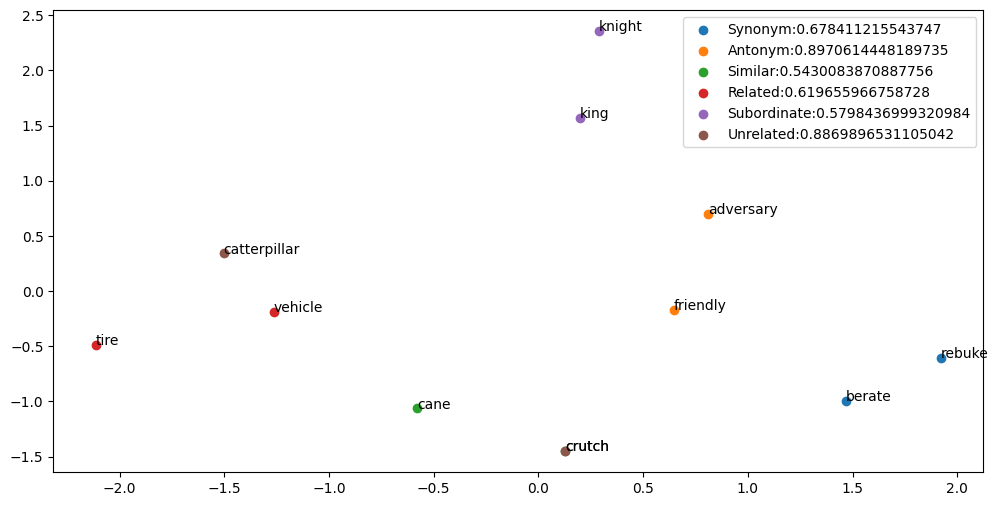

In [132]:
# (a) Synonyms: berate - rebuke
berate_embedding = model['berate']
rebuke_embedding = model['rebuke']
synonym_distance = model.distance('berate','rebuke')

# (b) Antonyms: adversary - friendly
adversary_embedding = model['adversary']
friendly_embedding = model['friendly']
antonym_distance = model.distance('adversary','friendly')

# (c) Similar: crutch - cane
crutch_embedding = model['crutch']
cane_embedding = model['cane']
similar_distance = model.distance('crutch','cane')

# (d) Related: vehicle - tire
vehicle_embedding = model['vehicle']
tire_embedding = model['tire']
related_distance = model.distance('vehicle','tire')

# (e) Subordinate: mattres - frame
mattress_embedding = model['knight']
frame_embedding = model['king']
subordinate_distance = model.distance('knight','king')

# (f) Unrelated: cattapilar - crutch
caterpillar_embedding = model['caterpillar']
crutch_embedding = model['crutch']
unrelated_distance = model.distance('crutch','caterpillar')

pca_embeddings = PCA(n_components=2).fit_transform([
    berate_embedding, rebuke_embedding, adversary_embedding, friendly_embedding, crutch_embedding,
    cane_embedding, vehicle_embedding, tire_embedding, mattress_embedding, frame_embedding,
    caterpillar_embedding
])

words = ['berate', 'rebuke','adversary','friendly','crutch','cane','vehicle','tire','knight','king','catterpillar']
word_pairs = [('berate', 'rebuke'),('adversary','friendly'),('crutch','cane'),('vehicle','tire'),('knight','king'),('catterpillar','crutch')]
pair_descriptions = ['Synonym', 'Antonym', 'Similar','Related', 'Subordinate','Unrelated']
pair_distances = [synonym_distance, antonym_distance, similar_distance, related_distance, subordinate_distance, unrelated_distance]

plt.figure(figsize=(12, 6))
for (word_1, word_2), label, distance in zip(word_pairs, pair_descriptions, pair_distances):
    word_1_index = words.index(word_1)
    word_2_index = words.index(word_2)

    word_1_embedding = pca_embeddings[word_1_index, :]
    word_2_embedding = pca_embeddings[word_2_index, :]

    x = [word_1_embedding[0], word_2_embedding[0]]
    y = [word_1_embedding[1], word_2_embedding[1]]
    plt.scatter(x, y, label=f"{label}:{distance}")
    plt.text(word_1_embedding[0], word_1_embedding[1], word_1)
    plt.text(word_2_embedding[0], word_2_embedding[1], word_2)
    
plt.legend()


The plot above shows the embeddings for each pair word in a 2 dimensional space with a legend describing the color for each pair and the distances associated with each. We can see the models don't do a bad job of plotting each pair. The only exceptions are the synonyms and antonyms. Oddly enough the antonyms are very close compared to all other embeddings. The plot doesn't give much indication of the similarity between each word embedding given we have pairs such as antonyms so close, yet the distances tell another story. The distances do in fact do a good job at showing how a pair could/could not be related.

The synonyms defined are above a desired threshold for finding synonyms via the API. Ideally the distance between two synonyms would be less than 0.5, regardless of the threshold. This is only by the assumption that the model would yield vectors close to each other for the pair. We can see via the API this is not always the case. In this case the plot doesn't do a bad job at showing how related the pair is.

The antonyms are accurate. I do expect the distance between two antonyms to be close to 1, or 180 degrees if we plot it out. The reasoning behind this is that the two words are opposite of each other. Therefore their vectors should be too, hence a distance as close as 1 should be accurate. What I do find odd is how close the pair is on the plot. In this case, the distance does a better job at showing these are antonyms.

The similar pair word is more or less accurate. We can be a bit looser when determining a threshold for similar words. Ideally this threshold would always be above 0.5 yet two words can be similar if given the right context. Due to this I think the model doesn't do a bad job at determining the pair is similar. The distance compared with the plot could allow us to deduce these two are similar.

The related pair is interesting since the distance isn't too high yet the map shows them fairly close. I think in this case both the embeddings and the distance can allow us to determine the pair of words are similar. 

The subordinate pair is pretty obvious on the map - given, I did choose a pretty easy pair. The plot shows them to be fairly close and their distance is smaller than that of the related pair. I do think we can use the plot to determine their relatedness.

The API does a pretty good job at showing the unrelatedness for the unrelated pair with a distance close to 0.9. I would've imagined the plot to show these two embeddings very far from each other rather than so close. Due to this I do think their distance is a more accurate show of how unrelated the pair is. 

Overall the map does a good job of clustering each pair. Each pair has something tied to it, i.e. similarity, unrelated, antonym, etc. Notice how the model cluster's each pair, outside of the unrelate one, close together. That is due to each pair being related to each other somehow, whether its through their unrelated or relatedness.

## Part B: Exploring Contextual Word Embeddings

Now we will compare the static embeddings of Part A with contextual embeddings produced by SpaCy. The imports from Part A cover everything we need here.

SpaCy automatically builds a contextual embedding for each token it processes. Here is a function that returns a list of embedding vectors and the corresponding list of words for a given input sentence:

In [134]:
def tokenize(sentence, nlp):
  doc = nlp(sentence)
  return [token.vector for token in doc], [token.text for token in doc]

We can use this function to recover the contextual embedding vector for a given word in a sentence:

In [135]:
def embed_word_contextual(word, sentence, nlp):
  embeddings, words = tokenize(sentence, nlp)
  return embeddings[words.index(word)]

This function just demonstrates how to find the right embedding. You will not want to call it repeatedly on the same sentence because it tokenizes every time it is called.

Here is a data structure that indicates a "word" and sets of sentences representing various senses of that word:

In [136]:
senses = {"word": "bank",
          "river": [
              "river bank",
              "I buried the money in the river bank",
              "I buried the money in the bank",
              "on the bank of the Ohio river",
              "on the bank of the Ohio",
              "I slid down the bank",
              "Silt deposits covered the bank",
              "I left my favorite pen on the bank",
              "Fortunately, no one was hurt sliding down the bank",
              "The bank was slippery and treacherous",
            ],
          "money": [
              "money bank",
              "The bank is a safe place to store your wealth",
              "The bank is a safe place to store your money",
              "The savings bank is a safe place to store your money",
              "I deposited the money in the bank",
              "The bank failure caused havoc in the financial markets",
              "I left my favorite pen at the bank",
              "The bank teller lives down by the river",
              "Fortunately, no one was hurt during the bank robbery",
              "The bank robber was slippery and treacherous",
            ],
          }

**(5 points)** Again, use PCA to create a two-dimensional plot of each of the instances of 'bank' in the above sentences together in a single diagram. Analyze the groupings you find in your plot. Do they make sense? Are the river and money senses of bank adequately separated? Can you identify the commonalities among the various instances of 'bank' in each cluster?

**(5 points)** Create your own example of a word that has two or more senses. Find ten sentences in ```small.txt``` containing your word for each of the senses you identify. Repeat your analysis on the examples you generated.

**(5 points)** For each of the words in the Part A plot, average the contextual embeddings for each occurrence of the word in ```small.txt```, then plot the results as you did in Part A. Compare this plot to your plot from Part A. Do the words congregate in the same way? What are the significant differences between the two plots? Can you identify an explanation for any significant differences?

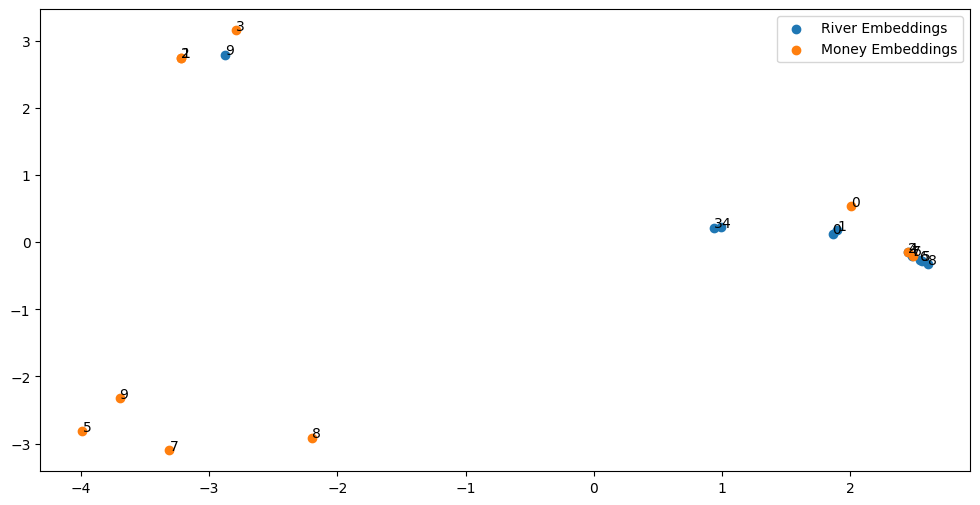

In [215]:
plt.figure(figsize=(12, 6))
embeddings = {
    'river': [],
    'money': []
}
word = senses['word']
for sense in ['river','money']:
    sentences = senses[sense]
    for sentence in sentences:
        embedding = embed_word_contextual(word, sentence, nlp)
        embeddings[sense].append(embedding)

# reduce dimensions
embeddings_ = embeddings['river'] + embeddings['money']
pca_embeddings = PCA(n_components=2).fit_transform(embeddings_)

# keep in mind first ten belong to river and the rest to money 
pca_river = pca_embeddings[:10, :]
pca_money = pca_embeddings[10:, :]

plt.scatter(pca_river[:, 0], pca_river[:, 1], label='River Embeddings')
for i in range(10):
    plt.text(pca_river[i, 0], pca_river[i, 1], str(i))

plt.scatter(pca_money[:, 0], pca_money[:, 1], label='Money Embeddings')
for i in range(10):
    plt.text(pca_money[i, 0], pca_money[i, 1], str(i))
plt.legend()

In [160]:
print('Sentences and indexes')
for sense in ['river','money']:
    sentences = senses[sense]
    for i, s in enumerate(sentences):
        print(f"{i}. {sense}: {s}")

Sentences and indexes
0. river: river bank
1. river: I buried the money in the river bank
2. river: I buried the money in the bank
3. river: on the bank of the Ohio river
4. river: on the bank of the Ohio
5. river: I slid down the bank
6. river: Silt deposits covered the bank
7. river: I left my favorite pen on the bank
8. river: Fortunately, no one was hurt sliding down the bank
9. river: The bank was slippery and treacherous
0. money: money bank
1. money: The bank is a safe place to store your wealth
2. money: The bank is a safe place to store your money
3. money: The savings bank is a safe place to store your money
4. money: I deposited the money in the bank
5. money: The bank failure caused havoc in the financial markets
6. money: I left my favorite pen at the bank
7. money: The bank teller lives down by the river
8. money: Fortunately, no one was hurt during the bank robbery
9. money: The bank robber was slippery and treacherous


The plot above shows the embeddings for each sense of the word `bank`. At a glance we can see the model does a good job at creating the clusters. Let's look at the ones that are clustered together yet are different senses.

The list of sentences above allows us to track a sentence on the plot by its sense and index. Using the list we can see the model clustered three sentences (1,2,3) from the money sense near sentence 9 from the river sense. Using the indexes we see the sentences aren't all that similar yet both speak about the bank. Specifically, the river sentence speaks about a bank being slippery and treacherous. It's funny to see the model cluster such a sentence near the others given the others speak highly of the bank. This might go back to our previous embeddings where the model clustered closely antonyms. This might be the reason those sentences are clustered together. 

To the right of the plot we see the sentences 5,6 from the money sense clustered together with the sentences 2,5,6,7,8 from the river sense. Sentence 6 (money) and 7 (river) on both senses should always be clustered given they are the same. The other sentences from the river sense speak about sliding down a bank, therefore it does make sense they are clustered together. Yet there isn't a clear reason why sentence 5 from the money sense would be clustered along these sentences as well aside from having the word bank in it. This is somewhat odd given the sense around all those sentences can be easily deduced.

Aside from these findings I think the model does a good job of clustering words contextually. Let's see how it pairs up with a new word: train. The word train is seen in the `small.txt` a couple of times with different meanings: learning and a vehicle.

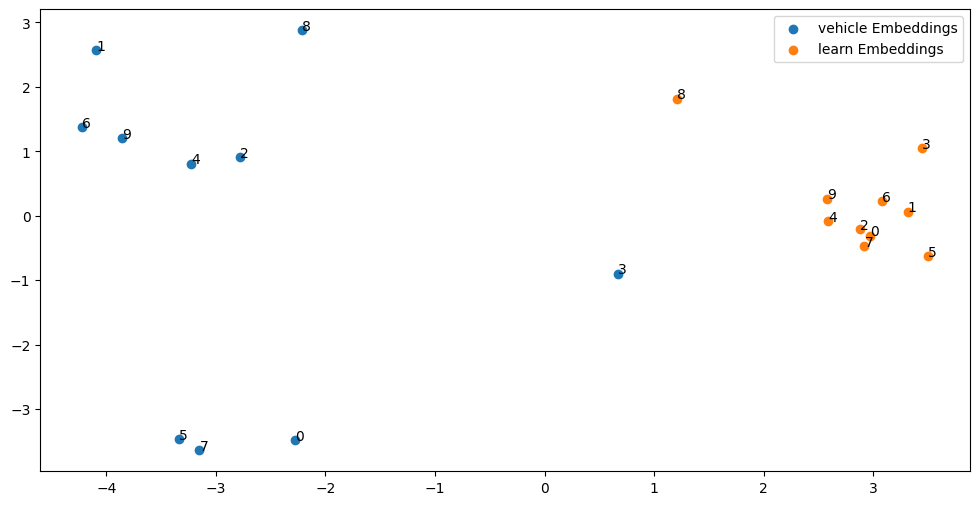

In [223]:
# custom word: train 
# senses: vehicle / learn
train_senses = {"word": "train",
          "vehicle": [
              393,2299,3440,8435,8754,11106,12445,12544,12644,13276
            ],
          "learn": [
              1570,6687,8111,10883,11859,15468,18954,23278,48878,28858
            ],
          }
small_  = open('data/small.txt', 'r').readlines()

plt.figure(figsize=(12, 6))
embeddings = {
    'vehicle': [],
    'learn': []
}
word = train_senses['word']
for sense in ['vehicle','learn']:
    sentences = train_senses[sense]
    for sentence_index in sentences:
        sentence = small_[sentence_index]
        embedding = embed_word_contextual(word, sentence, nlp)
        embeddings[sense].append(embedding)

# reduce dimensions
embeddings_ = embeddings['vehicle'] + embeddings['learn']
pca_embeddings = PCA(n_components=2).fit_transform(embeddings_)

# keep in mind first ten belong to automobile and the rest to learn 
pca_river = pca_embeddings[:10, :]
pca_money = pca_embeddings[10:, :]

plt.scatter(pca_river[:, 0], pca_river[:, 1], label='vehicle Embeddings')
for i in range(10):
    plt.text(pca_river[i, 0], pca_river[i, 1], str(i))

plt.scatter(pca_money[:, 0], pca_money[:, 1], label='learn Embeddings')
for i in range(10):
    plt.text(pca_money[i, 0], pca_money[i, 1], str(i))
plt.legend()

In [224]:
print('Sentences and indexes')
for sense in ['vehicle','learn']:
    sentences_index = train_senses[sense]
    for i, s in enumerate(sentences_index):
        print(f"{i}. {sense}: {small_[s]}")

Sentences and indexes
0. vehicle: The China Orient Express train does not have a satellite system, but we stop en-route, and you are able to send emails when we stay over in hotels.

1. vehicle: From Milan Central train station, take the MM2 underground line (green) towards Famagosta and alight at Cadorna.

2. vehicle: Loud stereo music may have prevented a school bus driver from hearing a locomotive warning horn moments before the train and bus collided, killing him and a young passenger, authorities said.

3. vehicle: TRAVELING TO CHINA: The border is about an hour from downtown Hong Kong by train through the colony's rural New Territories. Everyone must show their travel documents to immigration officials at a huge border checkpoint before leaving.

4. vehicle: Swartz said four toys made the list because of small parts that could choke a child: _"My Train," a wooden train set made by Montgomery Schoolhouse of Vermont.

5. vehicle: “Flexible staff, even breakfast was provided earlier

The plot shows the contextual embeddings obtained from each sentence for each word. We can see this word, train, is more easily delineated. 

In [284]:
# contextual embeddings part A
import numpy as np

words = ['paris', 'istanbul','moscow','france','turkey','russia','cat','dog','truck','train','two','three','four']
word_embeddings = []
for word in words:
    # get all sentences that match the word
    sentences = []

    for sen in small_:
        if word in sen.split(' '):
            sentences.append(sen)

    embeddings = []
    for sentence in sentences:
        embedding = embed_word_contextual(word, sentence, nlp)
        embeddings.append(embedding)
    word_embeddings.append(np.mean(embeddings, axis=1) if len(embeddings) > 1 else [])

13 13


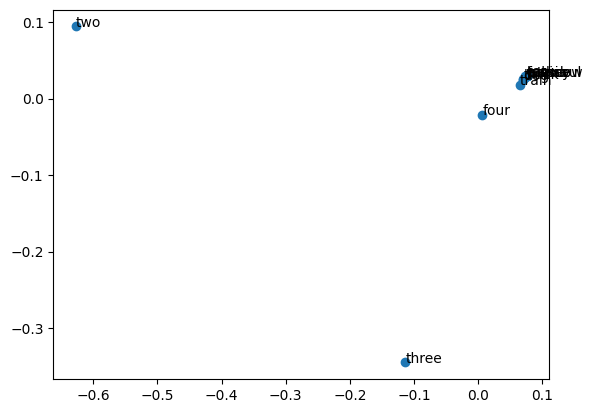

In [285]:
# embeddings are of different sizes, therefore we pad
max_size = max(map(len, word_embeddings))

padded_embeddings = []
for embedding in word_embeddings:
    if len(embedding) < max_size:
        difference = max_size - len(embedding)        
        padded_embeddings.append(list(embedding) + [0]*difference)
    else:
        padded_embeddings.append(list(embedding))

# perform PCA
pca_embedding = PCA(n_components=2).fit_transform(padded_embeddings)
pca1 = pca_embedding[:, 0]
pca2 = pca_embedding[:, 1]

plt.scatter(pca1, pca2)
for i, word in enumerate(words):
    plt.text(pca1[i], pca2[i], word)

For each word the script averages the contextual embedding for each word, if found in the corpus, pads the average embedding to match the maximum embedding length with zeros, and reduces to 2 dimensions. The plot isn't really accurate at all. Given we are looking for sentences that contain the words to build the contextual embedding, there is no guarantee the model will be able to yield contextual embeddings - the plot is evidence of that. 

Given our procedure, the plot doesn't really show us an accurate picture of contextual embeddings. I think the words that are all clustered together are those that either did not yield matching sentences in the corpus or were added a lot of padding to match the maximum dimension space.

## Extra Credit


**(2 points)**: Use the annoy package (https://github.com/spotify/annoy) to index all of the words in small.txt. Show the ten nearest neighbors of each occurrence of 'bank' in the bank sentences, and of each occurrence of your selected ambiguous word in the sentences you selected. Do the results make sense? Can you draw any new conclusions from the results? This exercise is entirely optional.